# Modeling Ames Housing Data
## Part 1: Data Cleaning

**Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

**Load Data**

In [2]:
test_data = "./datasets/test_data_CLEAN.csv" #might have to add a second period in the relative file path, this file was moved into a folder before and now this is the path that works
train_data = "./datasets/train.csv"  #might have to add a second period in the relative file path, this file was moved into a folder before and now this is the path that works
test = pd.read_csv(test_data)
train = pd.read_csv(train_data)
test_df = test
df = train
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [3]:
df.shape

(2051, 81)

**Correct Data Types**

Due to the size of the data frame. The datatypes are analyzed 15 at a time.

In [4]:
columns = df.columns

df[columns[45:75]].dtypes

2nd Flr SF           int64
Low Qual Fin SF      int64
Gr Liv Area          int64
Bsmt Full Bath     float64
Bsmt Half Bath     float64
Full Bath            int64
Half Bath            int64
Bedroom AbvGr        int64
Kitchen AbvGr        int64
Kitchen Qual        object
TotRms AbvGrd        int64
Functional          object
Fireplaces           int64
Fireplace Qu        object
Garage Type         object
Garage Yr Blt      float64
Garage Finish       object
Garage Cars        float64
Garage Area        float64
Garage Qual         object
Garage Cond         object
Paved Drive         object
Wood Deck SF         int64
Open Porch SF        int64
Enclosed Porch       int64
3Ssn Porch           int64
Screen Porch         int64
Pool Area            int64
Pool QC             object
Fence               object
dtype: object

Data Types needed to be changed
- Year Built - convert to home age column 
- Year Remod/Add -convert to age
- Garage Yr Blt - convert to age

**Handle Null/Missing Values**

There are 18 columns with missing values. A few of these columns will be dropped, but the missing values for the ordinal data columns will be replaced with zeroes because the absence of a feature will be ranked as 0.

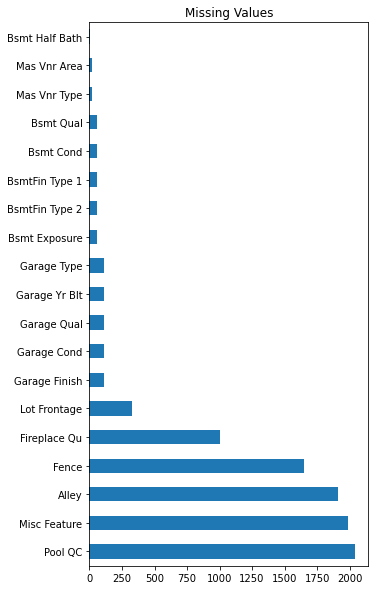

In [5]:
#All columns with missing values are plotted.
missing_values = df[columns].isnull().sum().sort_values()[:-20:-1]
plt.figure(figsize = (5,10))
plt.title("Missing Values")
missing_values.plot(kind = 'barh');

**Drop Columns**

The dropped columns below are either too specific or are missing significant data and will not positively contribute to the model. Ordinal data types will replace missing values with 0 to treat that instance as an absence of the feature. Categorical columns will likely be dropped.

Fireplace Qu and Pool Qu columns will have its null values assigned the value of zero instead of dropped to be treated as an absence of that feature. This is done in the ordinal data section.

In [6]:
df = df.drop(columns = ['PID','Misc Feature', 'Alley', 'Yr Sold', 'Sale Type','Lot Frontage'])

df.columns

Index(['Id', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars',
       'G

**Assign Hierarchy Values to Ordinal Data**


**Ordinal Features**
1. Utilities 
2. Land Slope 
3. Overall Qual 
4. Overall Cond 
5. Exter Qual
6. Exter Cond
7. Bsmt Cond
8. Bsmt Qual
9. Bsmt Exposure
10. BsmtFin Type 1
11. BsmtFin Type 2
12. Heating QC
13. Electrical
14. Kitchen Qual
15. FireplaceQu
16. Garage Finish
17. Garage Qual
18. Garage Cond
19. Paved Drive
20. Pool QC
21. Fence

*Ordinize* function converts ordinal text data to numeric hierarchy.

In [7]:

def ordinize(df):

    df['Utilities'] = df['Utilities'].map({'AllPub': 3,
                                            'NoSeWa' : 2,
                                           'NoSewr': 1})

    df['Land Slope'] = df['Land Slope'].map({'Gtl': 3,
                                            'Mod' : 2,
                                           'Sev': 1})

    df['Exter Qual'] = df['Exter Qual'].map({'Ex': 5,
                                            'Gd' : 4,
                                           'TA': 3,
                                              'Fa': 2,
                                              'Po': 1})
    
    
    df['Lot Shape'] = df['Lot Shape'].map({'Reg': 3,
                                            'IR1' : 2,
                                           'IR2': 1,
                                              'IR3': 0})


    df['Exter Cond'] = df['Exter Cond'].map({'Ex': 5,
                                            'Gd' : 4,
                                           'TA': 3,
                                              'Fa': 2,
                                              'Po': 1})

    df['Bsmt Cond'] = df['Bsmt Cond'].map({'Ex': 5,
                                            'Gd' : 4,
                                           'TA': 3,
                                              'Fa': 2,
                                              'Po': 1,
                                          np.nan : 0})
    
    df['Bsmt Qual'] = df['Bsmt Qual'].map({'Ex': 5,
                                            'Gd' : 4,
                                           'TA': 3,
                                              'Fa': 2,
                                              'Po': 1,
                                          np.nan : 0})

    df['Bsmt Exposure'] = df['Bsmt Exposure'].map({'Gd': 5,
                                            'Av' : 4,
                                           'Mn': 3,
                                              'No': 2}) 


    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map({'GLQ': 6,
                                            'ALQ' : 5,
                                            'BLQ': 4,
                                            'Rec': 3,
                                            'LwQ': 2,
                                            'Unf':1,}) 


    df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map({'GLQ': 6,
                                            'ALQ' : 5,
                                            'BLQ': 4,
                                            'Rec': 3,
                                            'LwQ': 2,
                                            'Unf':1,}) 

    df['Heating QC'] = df['Heating QC'].map({'Ex': 5,
                                                'Gd' : 4,
                                               'TA': 3,
                                                  'Fa': 2,
                                                  'Po': 1})

    df['Electrical'] = df['Electrical'].map({'SBrkr': 5,
                                                'FuseA' : 4,
                                               'FuseF': 3,
                                                  'FuseP': 2,
                                                  'Mix': 1})

    df['Kitchen Qual'] = df['Kitchen Qual'].map({'Ex': 5,
                                                'Gd' : 4,
                                               'TA': 3,
                                                  'Fa': 2,
                                                  'Po': 1})

    df['Fireplace Qu'] = df['Fireplace Qu'].map({'Ex': 5, 
                                                'Gd' : 4,
                                               'TA': 3,
                                                  'Fa': 2,
                                                  'Po': 1})

    df['Garage Qual'] = df['Garage Qual'].map({'Ex': 5,  
                                                'Gd' : 4,
                                               'TA': 3,
                                                  'Fa': 2,
                                                  'Po': 1})

    df['Garage Cond'] = df['Garage Cond'].map({'Ex': 5,  
                                                'Gd' : 4,
                                               'TA': 3,
                                                  'Fa': 2,
                                                  'Po': 1})
    
    df['Garage Finish'] = df['Garage Finish'].map({'Fin': 5,  
                                                'RFn' : 3,
                                               'Unf': 1,
                                                  np.nan: 0})


    df['Paved Drive'] = df['Paved Drive'].map({'Y': 3,
                                                'P' : 2,
                                               'N': 1})


    df['Pool QC'] = df['Pool QC'].map({'Ex': 10,  
                                                'Gd' : 8,
                                               'TA': 5,
                                                  'Fa': 4})

    df['Fence'] = df['Fence'].map({'GdPrv': 10,  
                                                'MnPrv' : 8,
                                               'GdWo': 5,
                                                  'MnWw': 4})
    
    return "No Errors"
    




ordinize(df)

'No Errors'

This fills in the null values of the ordinal columns with 0. The null values in the ordinal columns indicate an absence of that feature.

In [8]:
ordinal_columns = ['Fence','Pool QC', 'Garage Cond', 'Garage Qual', 'Fireplace Qu', 'BsmtFin Type 1','BsmtFin Type 2','Bsmt Exposure']

df.loc[:, ordinal_columns ] = df.loc[:, ordinal_columns].fillna(0)

Replace the null values in Garage Type to the category 'No Garage'. This will be one hot encoded with the other nominal data columns later.

In [9]:
df.shape

(2051, 75)

In [10]:
df['Garage Type'] = df['Garage Type'].replace(np.nan,'No Garage')

In [11]:
df['Garage Yr Blt']

0       1976.0
1       1997.0
2       1953.0
3       2007.0
4       1957.0
         ...  
2046    2007.0
2047    1961.0
2048    1929.0
2049    1956.0
2050    1999.0
Name: Garage Yr Blt, Length: 2051, dtype: float64

There were over 100 null values for the garage yr built existing because these are houses that do not have a garage. To avoid dropping large amounts of data, the null values are replaced with the year the house was built. This column was not simply dropped because it is ranked 10th best in correlation with Sale_Price. Replacing null values with the year the house was built was a fair compromise.

In [12]:
#gyb is garage year built, hyb is house year built
#because np.nan != np.nan, we will fill the nan values with something else first

df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna('filler')
df['Garage Yr Blt'] = [hyb if gyb == 'filler' else gyb for gyb, hyb in zip(df['Garage Yr Blt'], df['Year Built'])]

df['Garage Yr Blt'].sort_values(ascending = False)

1699    2207.0
1241    2010.0
144     2010.0
625     2009.0
1671    2009.0
         ...  
1793    1895.0
457     1895.0
1204    1890.0
136     1875.0
951     1872.0
Name: Garage Yr Blt, Length: 2051, dtype: float64

In [13]:
#fix typo in data
df['Garage Yr Blt'] = df['Garage Yr Blt'].replace(2207.0 , 2007.0)

df['Garage Yr Blt'].sort_values()

951     1872.0
136     1875.0
1204    1890.0
457     1895.0
1793    1895.0
         ...  
637     2009.0
81      2009.0
963     2009.0
1241    2010.0
144     2010.0
Name: Garage Yr Blt, Length: 2051, dtype: float64

Convert years of home,remodel, and garage to age columns.

In [14]:
df['age_of_home'] = 2021 - df['Year Built']
df['age_of_garage'] = 2021 - df['Garage Yr Blt']
df['age_of_remodel'] = 2021 - df['Year Remod/Add']
df = df.drop(columns = ['Year Built','Garage Yr Blt','Year Remod/Add'])
df.columns

Index(['Id', 'MS SubClass', 'MS Zoning', 'Lot Area', 'Street', 'Lot Shape',
       'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood',
       'Condition 1', 'Condition 2', 'Bldg Type', 'House Style',
       'Overall Qual', 'Overall Cond', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area',
       'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Cars',
       'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive'

In [15]:
#checking the progress of handling null values
columns = df.columns #red
df[columns].isnull().sum().sort_values(ascending = True)[:-20:-1]

Mas Vnr Type      22
Mas Vnr Area      22
Bsmt Full Bath     2
Bsmt Half Bath     2
Bsmt Unf SF        1
BsmtFin SF 2       1
Total Bsmt SF      1
BsmtFin SF 1       1
Garage Cars        1
Garage Area        1
Exter Qual         0
Exterior 2nd       0
Bsmt Qual          0
Exter Cond         0
Foundation         0
Roof Matl          0
Bsmt Cond          0
Bsmt Exposure      0
BsmtFin Type 1     0
dtype: int64

Enough of the missing values have been salvaged that the 25 rows with missing values will be dropped. This is roughly 1.2% of the data which is neglible.

In [16]:
df = df.dropna()
df.shape

(2026, 75)

Null Values have been removed.

In [17]:
columns = df.columns #red
df[columns].isnull().sum().sort_values()[:-20:-1]

age_of_remodel    0
Roof Matl         0
Exterior 2nd      0
Mas Vnr Type      0
Mas Vnr Area      0
Exter Qual        0
Exter Cond        0
Foundation        0
Bsmt Qual         0
Bsmt Cond         0
Bsmt Exposure     0
BsmtFin Type 1    0
BsmtFin SF 1      0
BsmtFin Type 2    0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Exterior 1st      0
Roof Style        0
dtype: int64

**One Hot Encode Nominal Data**

**Nominal Features**
1. PID
2. MS Subclass 
3. MS Zoning 
4. Street 
5. Land contour
6. Lot Config
7. Neighborhood
8. Condition 1
9. Condition 2
10. Bldg Type
11. House Style
12. Roof Style
13. Roof Matl
14. Exterior 1st
15. Exterior 2nd
16. Mas Vnr Type
17. Mas Vnr Area
18. Foundation
19. Heating
20. Central Air
21. Garage Type

In [18]:
df.shape

(2026, 75)

The following columns will not be dummified to avoid inserting to many noise parameters into the model.

- ID
- PID


In [19]:
nominal_columns= ['MS SubClass', 'MS Zoning', 'Street', 'Land Contour','Lot Config','Neighborhood','Condition 1', 'Condition 2','Bldg Type', 'House Style','Roof Style', 'Roof Matl',
                  'Exterior 1st', 'Exterior 2nd','Mas Vnr Type', 'Mas Vnr Area','Foundation','Heating','Central Air', 'Garage Type','Functional','Bsmt Exposure']

Compared against test data to match categorical data only if it has the same number of categories.

In [20]:
[len(df[i].unique()) for i in nominal_columns]

[16, 7, 2, 4, 5, 28, 9, 8, 5, 8, 6, 6, 15, 15, 4, 373, 6, 5, 2, 7, 8, 5]

In [21]:
#redefine nominal columns such that they have the same number of categories in the training data AND the test data. 
#Otherwise we get an diproportionate amount of columns between the train/test data.
nominal_columns = nominal_columns= ['Street',
 'Land Contour',
 'Lot Config',
 'Condition 1',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Foundation',
 'Central Air',
 'Garage Type',
 'Bsmt Exposure']

The function below one-hot-encodes the categorical columns

In [22]:
def thats_one_hot_encoder(df, nc):
    
    df = pd.get_dummies(data = df, columns = nc, drop_first = True)
    return df

df = thats_one_hot_encoder(df, nominal_columns)

df.shape

(2026, 116)

This is a very high column:row ratio. Additional Columns may be dropped if there is excessive variance.

**Filter Discrete and Continuous Data Types**

In [23]:
len(df._get_numeric_data().columns)

108

In [24]:
# df.select_dtypes(exclude=['int64','float64','uint8'])
#This was used to find columns that were not one hot encoded/numeric

In [25]:
report = df
report.to_csv('./datasets/train_data_CLEAN.csv',index = False)

## Part 2: Exploratory Data Analysis

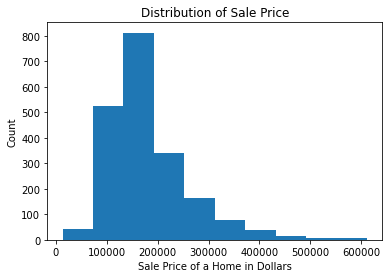

In [26]:
#the right skew will be converted to a more normal distribution using a log transformation
plt.hist(df['SalePrice']);
plt.title("Distribution of Sale Price")
plt.xlabel("Sale Price of a Home in Dollars")
plt.ylabel("Count")
plt.savefig("./Plots_&_Images/distribution_saleprice.png", bbox_inches="tight")

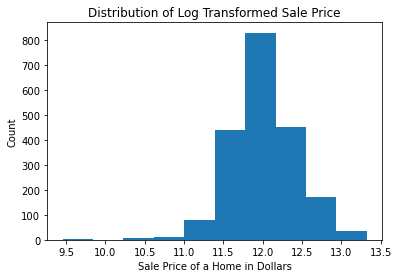

In [27]:
plt.hist(np.log(df['SalePrice']))
plt.title("Distribution of Log Transformed Sale Price")
plt.xlabel("Sale Price of a Home in Dollars")
plt.ylabel("Count")
plt.savefig("./Plots_&_Images/distributionlog_saleprice.png", bbox_inches="tight")

Text(0.5, 1.0, 'Boxplot Indicating Sale Price Outliers')

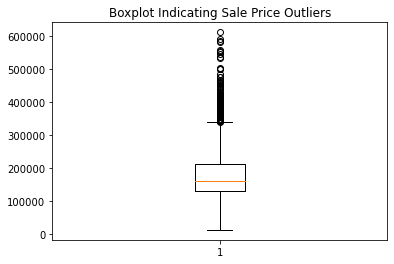

In [28]:
#all sale price outliers are in the upper quartile
plt.boxplot(train['SalePrice']);
plt.title("Boxplot Indicating Sale Price Outliers")

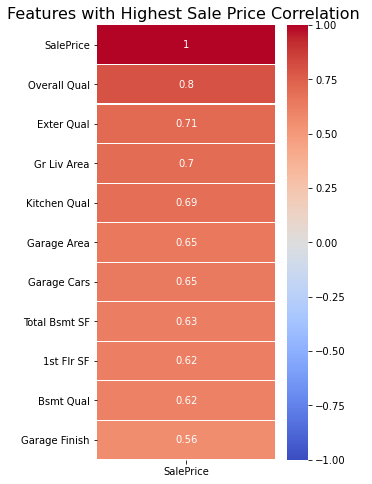

In [29]:
#The features most highly correlated with price
corr = df.corr()
plt.figure(figsize = (4,8))
sns.heatmap(corr[['SalePrice']].sort_values(by = "SalePrice", ascending=False)[:11], cmap = 'coolwarm',
            annot = True, vmin = -1, vmax = 1, linewidth = 0.1, linecolor = 'w');

plt.title("Features with Highest Sale Price Correlation ",fontsize = 16)

plt.savefig("./Plots_&_Images/highest_corr_heatmap.png", bbox_inches="tight")

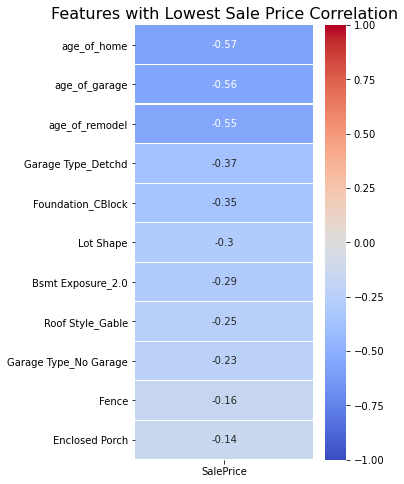

In [30]:
#The features most inversely correlated with price
corr = df.corr()
plt.figure(figsize = (4,8))
sns.heatmap(corr[['SalePrice']].sort_values(by = "SalePrice", ascending=True)[:11], cmap = 'coolwarm',
            annot = True, vmin = -1, vmax = 1, linewidth = 0.1, linecolor = 'w');


plt.title("Features with Lowest Sale Price Correlation", fontsize = 16)
plt.savefig("./Plots_&_Images/lowest_corr_heatmap.png", bbox_inches="tight")

In [31]:
corr_cols = corr[['SalePrice']].sort_values(by = "SalePrice", ascending=False)[:11].index

corr_cols

Index(['SalePrice', 'Overall Qual', 'Exter Qual', 'Gr Liv Area',
       'Kitchen Qual', 'Garage Area', 'Garage Cars', 'Total Bsmt SF',
       '1st Flr SF', 'Bsmt Qual', 'Garage Finish'],
      dtype='object')

Linear relationship between the top ten correlated values with sale price.

<Figure size 864x864 with 0 Axes>

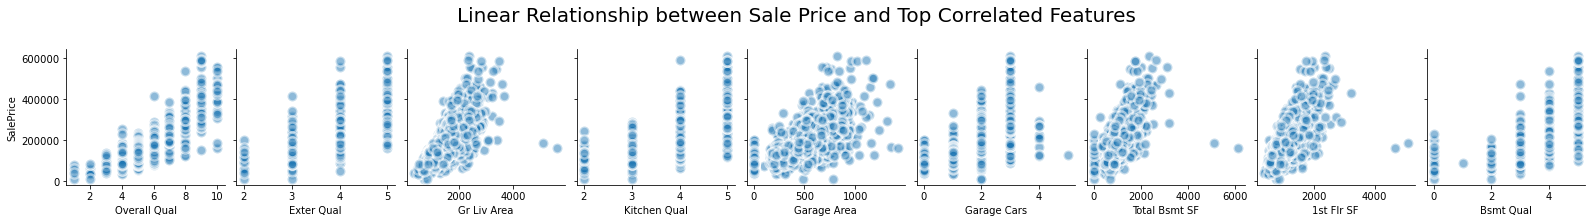

In [32]:
#Linear relationships are a good sign for LR model, no need to log transform
plt.figure(figsize = (12,12))
g = sns.pairplot(data = df,
             y_vars = ['SalePrice'],
             x_vars = ['Overall Qual', 'Exter Qual', 'Gr Liv Area',
       'Kitchen Qual', 'Garage Area', 'Garage Cars', 'Total Bsmt SF',
       '1st Flr SF', 'Bsmt Qual'],diag_kind = None,plot_kws=dict(s=100, linewidth=2.5, alpha=.5));

g.fig.suptitle("Linear Relationship between Sale Price and Top Correlated Features",y = 1.2, fontsize = 20)
plt.savefig("./Plots_&_Images/top10_linear_relationship.png", bbox_inches="tight")



plt.show()

Distributions of the top ten most correlated parameters. Some of these features would benefit from a power transformation to normally distribute the data

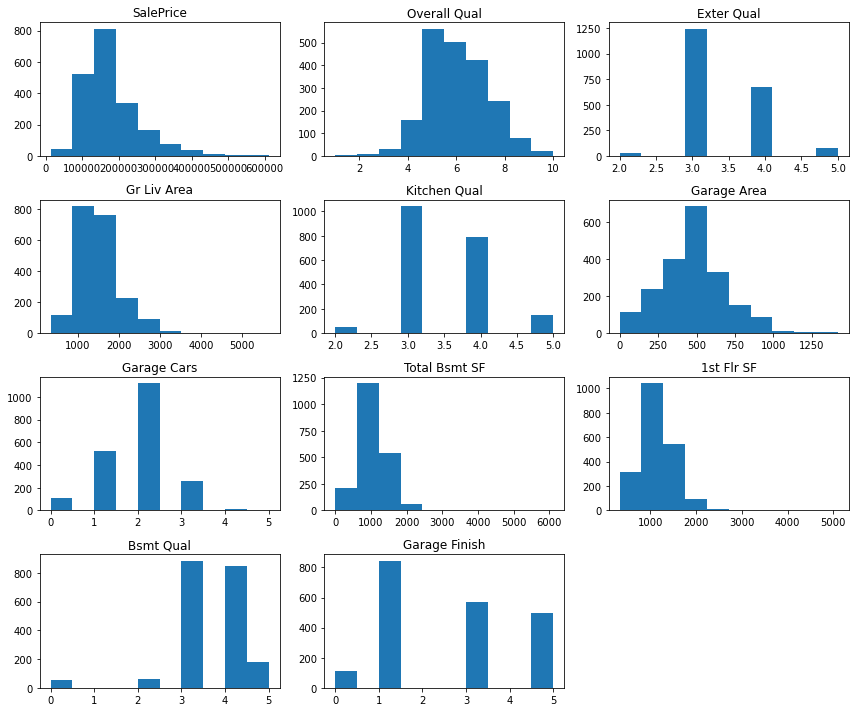

In [33]:
#Sale Price, Gr Liv Area, 
df[corr_cols].hist(figsize = (12,10), grid = False);
plt.tight_layout();

In [34]:
neg_corr_cols = corr[['SalePrice']].sort_values(by = "SalePrice", ascending=True)[:10].index

neg_corr_cols

Index(['age_of_home', 'age_of_garage', 'age_of_remodel', 'Garage Type_Detchd',
       'Foundation_CBlock', 'Lot Shape', 'Bsmt Exposure_2.0',
       'Roof Style_Gable', 'Garage Type_No Garage', 'Fence'],
      dtype='object')

Distribution of the ten inversely correltated features with sale price. These features require transformations to normally distribute their data.

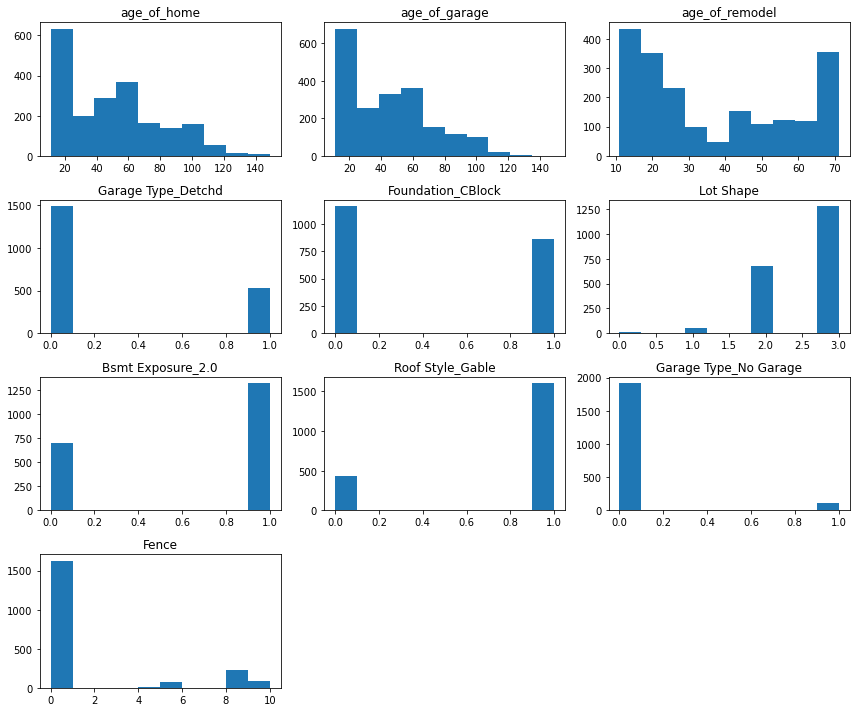

In [35]:

df[neg_corr_cols].hist(figsize = (12,10), grid = False);
plt.tight_layout();

## Baseline

Below are the baseline sale price and null_mse scores used to evaluate the models.

In [36]:
y = df['SalePrice']
baseline = np.mean(y)
baseline

180903.8637709773

In [37]:
null_mse = np.mean((y-baseline)**2)
null_mse

6255753308.305222

## Part 3: First Model

Here is the inital model with no polynomial features, scaler, regularization, or grid search.

In [38]:
df._get_numeric_data().columns[1:] #remove id columns from features

Index(['MS SubClass', 'Lot Area', 'Lot Shape', 'Utilities', 'Land Slope',
       'Overall Qual', 'Overall Cond', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond',
       ...
       'Garage Type_Attchd', 'Garage Type_Basment', 'Garage Type_BuiltIn',
       'Garage Type_CarPort', 'Garage Type_Detchd', 'Garage Type_No Garage',
       'Bsmt Exposure_2.0', 'Bsmt Exposure_3.0', 'Bsmt Exposure_4.0',
       'Bsmt Exposure_5.0'],
      dtype='object', length=107)

In [39]:
 
y = df['SalePrice'] #target parameter

#removes id feature and sale price target from feature list
features = [col for col in df._get_numeric_data().columns[1:] if col != 'SalePrice'] #predictor parameters

X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                y,
                                                test_size = 0.33)

lr = LinearRegression()
lr.fit(X_train,y_train)

train_preds = lr.predict(X_train)
test_preds  = lr.predict(X_test)


MSE_train = mean_squared_error(y_true = y_train, y_pred = train_preds)
MSE_test = mean_squared_error(y_true = y_test, y_pred = test_preds)

RMSE_train = mean_squared_error(y_true = y_train, y_pred = train_preds)**0.5
RMSE_test = mean_squared_error(y_true = y_test, y_pred = test_preds)**0.5

R2_train = lr.score(X_train, y_train)
R2_test = lr.score(X_test, y_test)

print(f"Train Mean Squared Error      : {MSE_train}")
print(f"Test Mean Squared Error       : {MSE_test}")

print(f"Train Root Mean Squared Error : {RMSE_train}")
print(f"Test Root Mean Squared Error  : {RMSE_test}")

print(f"Train R-Squared Score         : {R2_train}")
print(f"Test R-Squared Score          : {R2_test}")

Train Mean Squared Error      : 537536281.9680029
Test Mean Squared Error       : 1246541378.0950754
Train Root Mean Squared Error : 23184.82870258055
Test Root Mean Squared Error  : 35306.39287855778
Train R-Squared Score         : 0.9077891012533235
Test R-Squared Score          : 0.8245270844962137


The large variation from train R^2 to test R^2 indicates the data is overfit due to the excessive amount of columns. The next model attempts to minimize this effect with standardscaler and LassoCV regression techniques.

We don't have y_actuals for the real test data so, residual plotting with be done using the the training data.

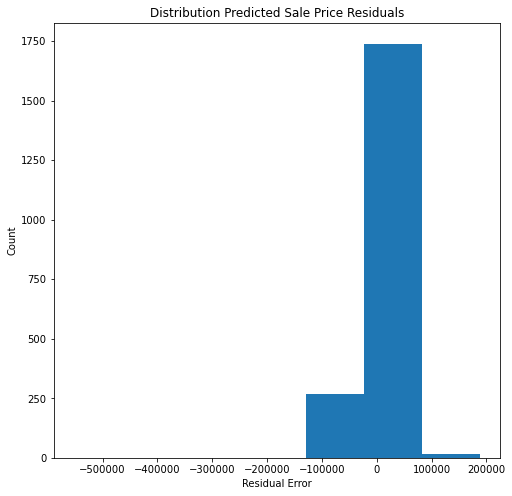

In [40]:
preds_1 = lr.predict(X)
resids_1 = y - preds_1
plt.figure(figsize = (8,8))
plt.hist(resids_1, bins = 7);
plt.title("Distribution Predicted Sale Price Residuals")
plt.ylabel("Count")
plt.xlabel("Residual Error")
plt.savefig("./Plots_&_Images/residuals_hist_firstmodel.png", bbox_inches="tight")

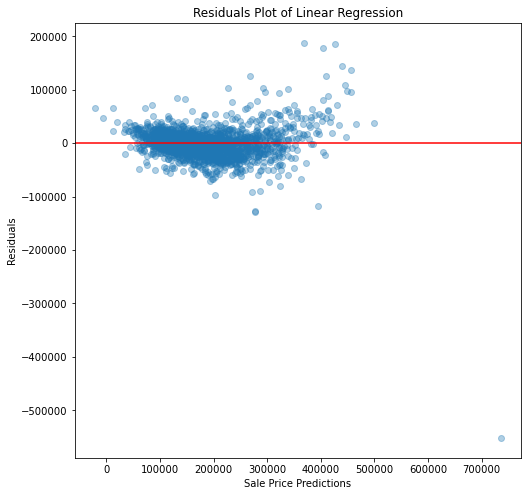

In [41]:
plt.figure(figsize = (8,8))
plt.scatter(preds_1, resids_1,alpha = .35); #x axis is predicted values, y axis is residuals
plt.title('Residuals Plot of Linear Regression')
plt.xlabel("Sale Price Predictions")
plt.ylabel("Residuals")
plt.axhline(0, color = 'red')
plt.savefig("./Plots_&_Images/residuals_scatter_firstmodel.png", bbox_inches="tight")

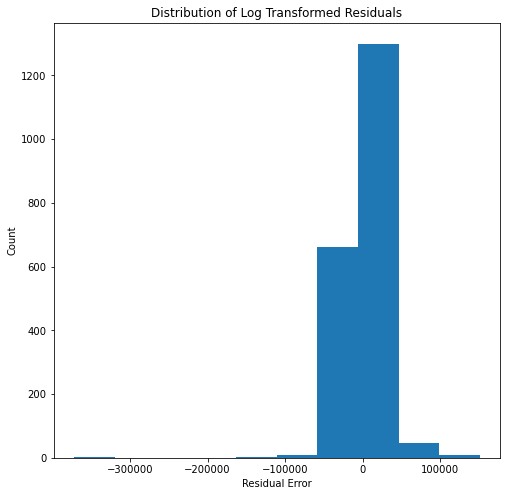

In [42]:
#not a significant difference in distribution of residuals using log transformation
lr_log = LinearRegression()
lr_log.fit(X,np.log(y))

preds_log = lr_log.predict(X)

resids_log = (y- np.exp(preds_log))
plt.figure(figsize = (8,8))
plt.hist(resids_log, bins = 10);
plt.title("Distribution of Log Transformed Residuals")
plt.ylabel("Count")
plt.xlabel("Residual Error")
plt.savefig("./Plots_&_Images/residualslog__hist_firstmodel.png", bbox_inches="tight")

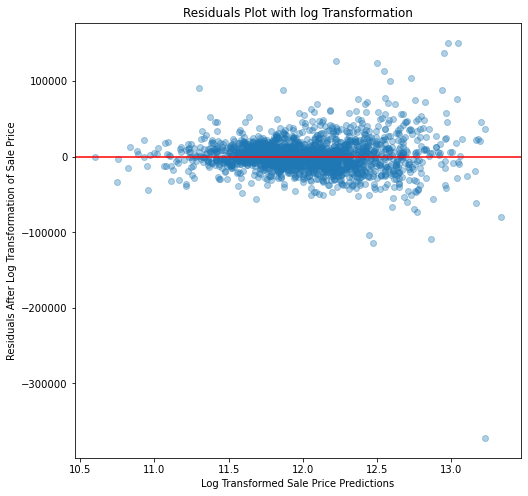

In [43]:
#better distribution of X, closer to homescedasticity
plt.figure(figsize = (8,8))
plt.scatter(preds_log, resids_log, alpha = .35); #x axis is predicted values, y axis is residuals
plt.title('Residuals Plot with log Transformation')
plt.xlabel("Log Transformed Sale Price Predictions")
plt.ylabel("Residuals After Log Transformation of Sale Price")
plt.axhline(0, color = 'red')
plt.savefig("./Plots_&_Images/residualslog__scatter_firstmodel.png", bbox_inches="tight")

In [44]:
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coef'       : lr.coef_
})

coef_df.sort_values(by = 'coef', ascending = False)[:11]

,feature,coef
86,Roof Matl_Membran,679642.083701
89,Roof Matl_WdShngl,675281.087468
88,Roof Matl_WdShake,667133.712819
85,Roof Matl_CompShg,665129.455856
87,Roof Matl_Tar&Grv,639643.905164
75,House Style_2.5Fin,58856.576781
101,Garage Type_No Garage,35743.842375
63,Condition 1_PosA,27162.499032
98,Garage Type_BuiltIn,23746.957546
97,Garage Type_Basment,19273.604032


**Sale Price Predictions for the first model.**

In [45]:
def post_predictions_model(df, submission_num, model_name):
    """Given the dataframe, submission number and name of a fit model, the function saves predictions for submission in the kaggle requested format."""
    
    #create predictions through the selected model
    features = [col for col in df._get_numeric_data().columns[1:] if col != 'SalePrice'] #predictor parameters
    X_test_df = df[features]
    model_preds = model_name.predict(X_test_df)

    #place data in dataframe and save to csv
    submiss_df = pd.DataFrame({
        'Id': df['Id'],
        'SalePrice': model_preds
    })

    report = submiss_df
    report.to_csv(f'./datasets/submission_{submission_num}.csv',index = False)
    


In [46]:
# submission_1.csv saved in the datasets file
post_predictions_model(test_df, 1, lr)

## Second Model: Use of Standardscaler and LassoCV

In [47]:

y = df['SalePrice'] #target parameter

features = [col for col in df._get_numeric_data().columns[1:] if col != 'SalePrice'] #predictor parameters

X = df[features]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                y,
                                                test_size = 0.33)

lasso_alphas = np.logspace(0, 3, 100)
    
model_pipeline = Pipeline([
                            ("std_scaler", StandardScaler()),
                            ('Lasso_CV', LassoCV(alphas=lasso_alphas))])


model_pipeline.fit(X_train, y_train)


train_preds = model_pipeline.predict(X_train)
test_preds  = model_pipeline.predict(X_test)


MSE_train = mean_squared_error(y_true = y_train, y_pred = train_preds)
MSE_test = mean_squared_error(y_true = y_test, y_pred = test_preds)

RMSE_train = mean_squared_error(y_true = y_train, y_pred = train_preds)**0.5
RMSE_test = mean_squared_error(y_true = y_test, y_pred = test_preds)**0.5

R2_train = model_pipeline.score(X_train, y_train)
R2_test = model_pipeline.score(X_test, y_test)

print(f"Train Mean Squared Error      : {MSE_train}")
print(f"Test Mean Squared Error       : {MSE_test}")

print(f"Train Root Mean Squared Error : {RMSE_train}")
print(f"Test Root Mean Squared Error  : {RMSE_test}")

print(f"Train R-Squared Score         : {R2_train}")
print(f"Test R-Squared Score          : {R2_test}")



Train Mean Squared Error      : 599321138.6405418
Test Mean Squared Error       : 1646988574.7113276
Train Root Mean Squared Error : 24481.03630650757
Test Root Mean Squared Error  : 40583.10701155504
Train R-Squared Score         : 0.9043538024634525
Test R-Squared Score          : 0.7358278742357958


The model is slightly overfit but the score on training data is good. Unuseful features will be dropped to reduce the noise.

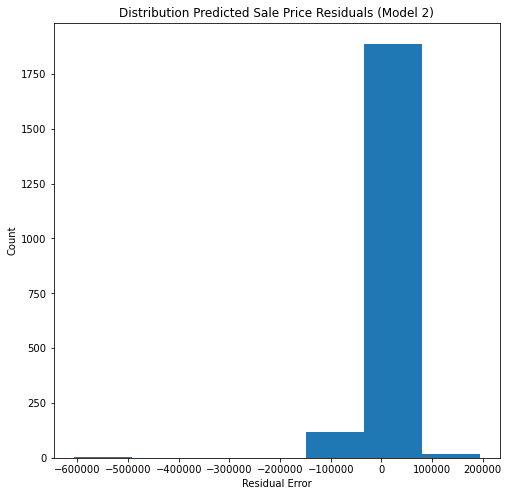

In [48]:
preds_2 = model_pipeline.predict(X)
resids_2 = y - preds_2
plt.figure(figsize = (8,8))
plt.hist(resids_2, bins = 7);
plt.title("Distribution Predicted Sale Price Residuals (Model 2)")
plt.ylabel("Count")
plt.xlabel("Residual Error")
plt.savefig("./Plots_&_Images/residuals_hist_secondmodel.png", bbox_inches="tight")

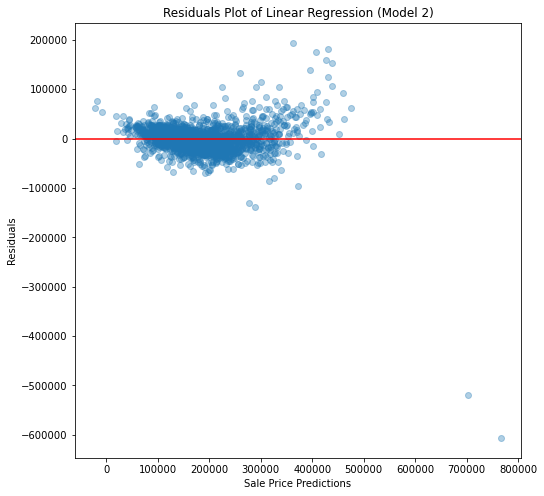

In [49]:
plt.figure(figsize = (8,8))
plt.scatter(preds_2, resids_2, alpha = .35); #x axis is predicted values, y axis is residuals
plt.title('Residuals Plot of Linear Regression (Model 2)')
plt.xlabel("Sale Price Predictions")
plt.ylabel("Residuals")
plt.axhline(0, color = 'red')
plt.savefig("./Plots_&_Images/residuals_scatter_secondmodel.png", bbox_inches="tight")

**Implementation on the test data**

In [50]:

y = df['SalePrice'] #target parameter


features = [col for col in df._get_numeric_data().columns[1:] if col != 'SalePrice'] #predictor parameters

#All training rows
X = df[features]

#All the testings rows(actual test data)
test_features = [col for col in test_df._get_numeric_data().columns[1:] if col != 'SalePrice'] #predictor parameters

#using only numeric columns
X_test_df = test_df[test_features]

lasso_alphas = np.logspace(0, 3, 100)
    
model_pipeline = Pipeline([
                            ("std_scaler", StandardScaler()),
                            ('Lasso_CV', LassoCV(alphas=lasso_alphas))])

#fit the pipeline model to the training data and predict sales prices for the y test data
model_pipeline.fit(X, y)

train_preds = model_pipeline.predict(X)
test_preds  = model_pipeline.predict(X_test_df)



MSE_train = mean_squared_error(y_true = y, y_pred = train_preds)
RMSE_train = mean_squared_error(y_true = y, y_pred = train_preds)**0.5
R2_train = model_pipeline.score(X, y)


print(f"Train Mean Squared Error      : {MSE_train}")
print(f"Train Root Mean Squared Error : {RMSE_train}")
print(f"Train R-Squared Score         : {R2_train}")



Train Mean Squared Error      : 836171498.8718423
Train Root Mean Squared Error : 28916.6301437744
Train R-Squared Score         : 0.8663356021789209


In [51]:
# submission_2.csv saved in the datasets file


def post_predictions(df, submission_num):
    """Given the dataframe and submission number a fit model, the function saves predictions for submission in the kaggle requested format."""
    
    submiss_df = pd.DataFrame({
        'Id': df['Id'],
        'SalePrice': test_preds
    })

    report = submiss_df
    report.to_csv(f'./datasets/submission_{submission_num}.csv',index = False)
    
post_predictions(test_df, 2)

The table below is a list of the top features contributing most to sale price.

In [52]:
coef_df2 = pd.DataFrame({
    'feature': X.columns,
    'coef'       : model_pipeline.named_steps['Lasso_CV'].coef_
})

coef_df2.sort_values(by = 'coef', ascending = False)[:11]

,feature,coef
23,Gr Liv Area,20304.394670
5,Overall Qual,15996.808807
8,Exter Qual,8808.863178
30,Kitchen Qual,7286.095313
7,Mas Vnr Area,4939.647913
36,Garage Area,4832.923188
33,Fireplace Qu,4485.986429
105,Bsmt Exposure_5.0,4382.029956
10,Bsmt Qual,4342.009519
20,1st Flr SF,3490.817869


## Third Model: Model with minimal Features utilizing StandardScaler and RidgeCV

In [53]:
categories = ['SalePrice','Overall Qual', 'Exter Qual', 'Gr Liv Area',
       'Kitchen Qual', 'Garage Area', 'Garage Cars', 'Total Bsmt SF',
       '1st Flr SF', 'Bsmt Qual','Garage Finish']

A dataframe of the 10 features most highly correlated with sale price.

In [54]:
df2 = df[['SalePrice','Overall Qual', 'Exter Qual', 'Gr Liv Area',
       'Kitchen Qual', 'Garage Area', 'Garage Cars', 'Total Bsmt SF',
       '1st Flr SF', 'Bsmt Qual','Garage Finish']]
df2.head()

,SalePrice,Overall Qual,Exter Qual,Gr Liv Area,Kitchen Qual,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Bsmt Qual,Garage Finish
0,130500,6,4,1479,4,475.0,2.0,725.0,725,3,3
1,220000,7,4,2122,4,559.0,2.0,913.0,913,4,3
2,109000,5,3,1057,4,246.0,1.0,1057.0,1057,3,1
3,174000,5,3,1444,3,400.0,2.0,384.0,744,4,5
4,138500,6,3,1445,3,484.0,2.0,676.0,831,2,1


In [55]:
#A dataframe of the top correlated categories was created for the test data to be fit into the next model.
test_df2 = test_df[['Overall Qual', 'Exter Qual', 'Gr Liv Area',
       'Kitchen Qual', 'Garage Area', 'Garage Cars', 'Total Bsmt SF',
       '1st Flr SF', 'Bsmt Qual','Garage Finish']]
test_df2.head()

,Overall Qual,Exter Qual,Gr Liv Area,Kitchen Qual,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Bsmt Qual,Garage Finish
0,6,3,1928,2,440,1,1020,908,2,1
1,5,3,1967,3,580,2,1967,1967,4,5
2,7,4,1496,4,426,2,654,664,4,3
3,5,4,968,3,480,2,968,968,3,1
4,6,3,1394,3,514,2,1394,1394,4,3


In [56]:

y = df2['SalePrice'] #target parameter

features = [col for col in df2._get_numeric_data().columns if col != 'SalePrice'] #predictor parameters

X = df2[features]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                y,
                                                test_size = 0.33)


# List of ridge alphas to test
ridge_alphas = np.logspace(0, 3, 100)

model_pipeline_2 = Pipeline([
                            ("std_scaler", StandardScaler()),
                            ('Ridge_CV', RidgeCV(alphas=ridge_alphas,
                                                 scoring = 'r2',
                                                 cv = 5))])


model_pipeline_2.fit(X_train, y_train)


train_preds = model_pipeline_2.predict(X_train)
test_preds  = model_pipeline_2.predict(X_test)


MSE_train = mean_squared_error(y_true = y_train, y_pred = train_preds)
MSE_test = mean_squared_error(y_true = y_test, y_pred = test_preds)

RMSE_train = mean_squared_error(y_true = y_train, y_pred = train_preds)**0.5
RMSE_test = mean_squared_error(y_true = y_test, y_pred = test_preds)**0.5

R2_train = model_pipeline_2.score(X_train, y_train)
R2_test = model_pipeline_2.score(X_test, y_test)

print(f"Train Mean Squared Error      : {MSE_train}")
print(f"Test Mean Squared Error       : {MSE_test}")

print(f"Train Root Mean Squared Error : {RMSE_train}")
print(f"Test Root Mean Squared Error  : {RMSE_test}")

print(f"Train R-Squared Score         : {R2_train}")
print(f"Test R-Squared Score          : {R2_test}")

Train Mean Squared Error      : 946198930.0898162
Test Mean Squared Error       : 1827998596.1780086
Train Root Mean Squared Error : 30760.346716020875
Test Root Mean Squared Error  : 42755.100235855
Train R-Squared Score         : 0.8447255694150918
Test R-Squared Score          : 0.7218233488189166


The model has less variance than the previous model, but less of the price change in the model can be described using the features in this model. In the next model polynomial features is utilized to find feature interactions with higher correlations.

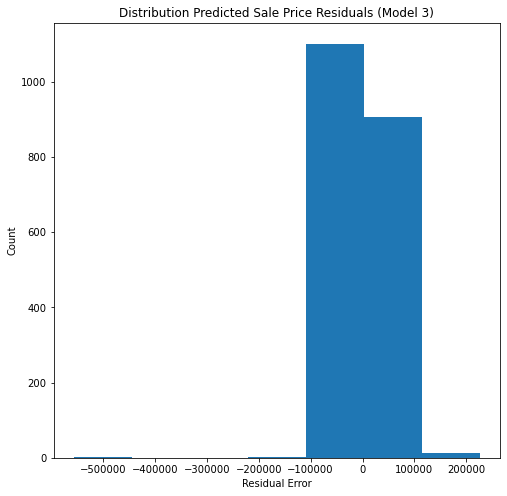

In [57]:
preds_3 = model_pipeline_2.predict(X)
resids_3 = y - preds_3
plt.figure(figsize = (8,8))
plt.hist(resids_3, bins = 7);
plt.title("Distribution Predicted Sale Price Residuals (Model 3)")
plt.ylabel("Count")
plt.xlabel("Residual Error")
plt.savefig("./Plots_&_Images/residuals_hist_thirdmodel.png", bbox_inches="tight")

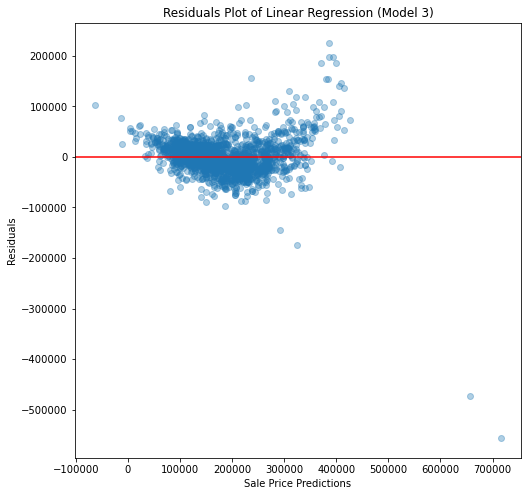

In [58]:
plt.figure(figsize = (8,8))
plt.scatter(preds_3, resids_3,alpha = .35); #x axis is predicted values, y axis is residuals
plt.title('Residuals Plot of Linear Regression (Model 3)')
plt.xlabel("Sale Price Predictions")
plt.ylabel("Residuals")
plt.axhline(0, color = 'red')
plt.savefig("./Plots_&_Images/residuals_scatter_thirdmodel.png", bbox_inches="tight")

**Implementation of the third model on the test data**

In [59]:

y = df2['SalePrice'] #target parameter


features = [col for col in df2._get_numeric_data().columns[1:] if col != 'SalePrice'] #predictor parameters

#All training rows
X = df2[features]

#All the testings rows(actual test data)
test_features = [col for col in test_df2._get_numeric_data().columns if col != 'SalePrice'] #predictor parameters

#using only numeric columns
X_test_df = test_df2[test_features]


# List of ridge alphas to test
ridge_alphas = np.logspace(0, 3, 100)

model_pipeline_2 = Pipeline([
                            ("std_scaler", StandardScaler()),
                            ('Ridge_CV', RidgeCV(alphas=ridge_alphas,
                                                 scoring = 'r2',
                                                 cv = 5))])


model_pipeline_2.fit(X, y)


train_preds = model_pipeline_2.predict(X)
test_preds  = model_pipeline_2.predict(X_test_df)

MSE_train = mean_squared_error(y_true = y, y_pred = train_preds)
RMSE_train = mean_squared_error(y_true = y, y_pred = train_preds)**0.5
R2_train = model_pipeline_2.score(X, y)


print(f"Train Mean Squared Error      : {MSE_train}")
print(f"Train Root Mean Squared Error : {RMSE_train}")
print(f"Train R-Squared Score         : {R2_train}")


Train Mean Squared Error      : 1199249545.4080803
Train Root Mean Squared Error : 34630.18257832436
Train R-Squared Score         : 0.8082965413907964


In [60]:
# submission_3.csv saved
post_predictions(test_df, 3)

The table below is a list of the top features contributing most to sale price.

In [61]:
coef_df3 = pd.DataFrame({
    'feature': X.columns,
    'coef'       : model_pipeline_2.named_steps['Ridge_CV'].coef_
})

coef_df3.sort_values(by = 'coef', ascending = False)[:11]



,feature,coef
2,Gr Liv Area,19007.591583
0,Overall Qual,17162.122310
3,Kitchen Qual,9907.700822
1,Exter Qual,9567.472898
7,1st Flr SF,9192.676122
8,Bsmt Qual,7284.632873
4,Garage Area,6300.598017
5,Garage Cars,4461.558714
9,Garage Finish,4327.863141
6,Total Bsmt SF,4273.660185


## Fourth Model: Model with ideal Features, this time using PolynomialFeatures with StandardScaler and RidgeCV

In [62]:
y = df2['SalePrice'] #target parameter

features = [col for col in df2._get_numeric_data().columns if col != 'SalePrice'] #predictor parameters

X = df2[features]


X_train, X_test, y_train, y_test = train_test_split(X,
                                                y,
                                                test_size = 0.33)



# List of ridge alphas to test
ridge_alphas = np.logspace(0, 3, 100)

model_pipeline_3 = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
                            ("std_scaler", StandardScaler()),
                            ('Ridge_CV', RidgeCV(alphas=ridge_alphas,
                                                 scoring = 'r2',
                                                 cv = 5))])


model_pipeline_3.fit(X_train, y_train)


train_preds = model_pipeline_3.predict(X_train)
test_preds  = model_pipeline_3.predict(X_test)



MSE_train = mean_squared_error(y_true = y_train, y_pred = train_preds)
MSE_test = mean_squared_error(y_true = y_test, y_pred = test_preds)

RMSE_train = mean_squared_error(y_true = y_train, y_pred = train_preds)**0.5
RMSE_test = mean_squared_error(y_true = y_test, y_pred = test_preds)**0.5

R2_train =  model_pipeline_3.score(X_train, y_train)
R2_test =  model_pipeline_3.score(X_test, y_test)

print(f"Train Mean Squared Error      : {MSE_train}")
print(f"Test Mean Squared Error       : {MSE_test}")

print(f"Train Root Mean Squared Error : {RMSE_train}")
print(f"Test Root Mean Squared Error  : {RMSE_test}")

print(f"Train R-Squared Score         : {R2_train}")
print(f"Test R-Squared Score          : {R2_test}")

Train Mean Squared Error      : 956556086.6162264
Test Mean Squared Error       : 1177421237.1747985
Train Root Mean Squared Error : 30928.24092340569
Test Root Mean Squared Error  : 34313.57220073128
Train R-Squared Score         : 0.8413701876651521
Test R-Squared Score          : 0.8245051053682444


This has increased increased accuracy and low variance compared to previous models.

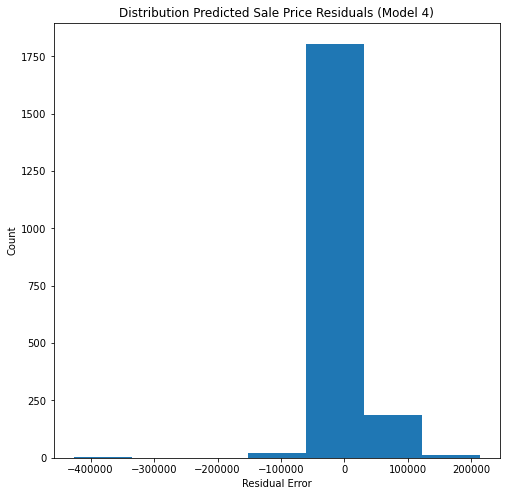

In [63]:
preds_4 = model_pipeline_3.predict(X)
resids_4 = y - preds_4
plt.figure(figsize = (8,8))
plt.hist(resids_4, bins = 7);
plt.title("Distribution Predicted Sale Price Residuals (Model 4)")
plt.ylabel("Count")
plt.xlabel("Residual Error")
plt.savefig("./Plots_&_Images/residuals_hist_fourthmodel.png", bbox_inches="tight")

The fan shape pattern indicates we need to run target vector through a power transformation.

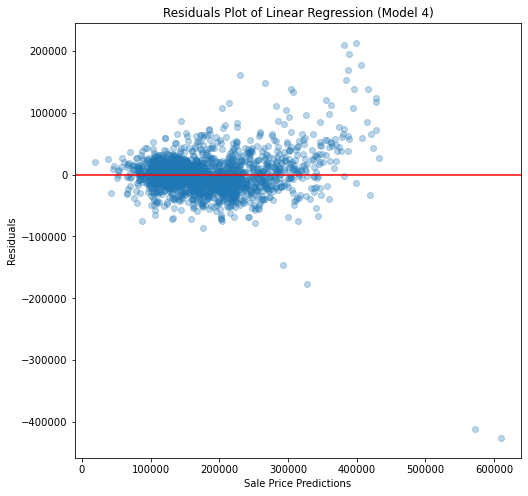

In [64]:
plt.figure(figsize = (8,8))
plt.scatter(preds_4, resids_4,alpha = .3); #x axis is predicted values, y axis is residuals
plt.title('Residuals Plot of Linear Regression (Model 4)')
plt.xlabel("Sale Price Predictions")
plt.ylabel("Residuals")
plt.axhline(0, color = 'red')
plt.savefig("./Plots_&_Images/residuals_scatter_fourthmodel.png", bbox_inches="tight")

**Implementation of the third model on the test data**

In [65]:

y = df2['SalePrice'] #target parameter


features = [col for col in df2._get_numeric_data().columns[1:] if col != 'SalePrice'] #predictor parameters

#All training rows
X = df2[features]

#All the testings rows(actual test data)
test_features = [col for col in test_df2._get_numeric_data().columns if col != 'SalePrice'] #predictor parameters

#using only numeric columns
X_test_df = test_df2[test_features]


# List of ridge alphas to test
ridge_alphas = np.logspace(0, 3, 100)

model_pipeline_3 = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
                            ("std_scaler", StandardScaler()),
                            ('Ridge_CV', RidgeCV(alphas=ridge_alphas,
                                                 scoring = 'r2',
                                                 cv = 5))])


model_pipeline_3.fit(X, y)


train_preds = model_pipeline_3.predict(X)
test_preds  = model_pipeline_3.predict(X_test_df)

MSE_train = mean_squared_error(y_true = y, y_pred = train_preds)
RMSE_train = mean_squared_error(y_true = y, y_pred = train_preds)**0.5
R2_train = model_pipeline_3.score(X, y)


print(f"Train Mean Squared Error      : {MSE_train}")
print(f"Train Root Mean Squared Error : {RMSE_train}")
print(f"Train R-Squared Score         : {R2_train}")


Train Mean Squared Error      : 721027277.2447598
Train Root Mean Squared Error : 26851.951088231184
Train R-Squared Score         : 0.8847417342548478


In [66]:

post_predictions(test_df, 4)

The table below is a list of the top features contributing most to sale price.

In [67]:
coef_df4 = pd.DataFrame({
    'Feature': model_pipeline_3.named_steps['poly'].get_feature_names(X.columns),
    'Coefficients': model_pipeline_3.named_steps['Ridge_CV'].coef_
})

coef_df4.sort_values(by = 'Coefficients', ascending = False)[:11]

,Feature,Coefficients
30,Gr Liv Area Kitchen Qual,19909.745579
12,Overall Qual Gr Liv Area,18260.808656
57,Total Bsmt SF Bsmt Qual,17380.149910
16,Overall Qual Total Bsmt SF,14016.257713
21,Exter Qual Gr Liv Area,11803.422967
32,Gr Liv Area Garage Cars,11629.352244
17,Overall Qual 1st Flr SF,11237.237907
41,Kitchen Qual 1st Flr SF,10565.236284
52,Garage Cars 1st Flr SF,8696.365020
35,Gr Liv Area Bsmt Qual,8437.750249


Below the data dictionary for the best model (model 4) was created and can be viewed in the README.md file

In [69]:
X.columns

Index(['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual',
       'Garage Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF',
       'Bsmt Qual', 'Garage Finish'],
      dtype='object')

In [70]:
data_dict_final_model = {
    'Overall Qual':['Rates the overall material and finish of the house (Ordinal)'],
    'Exter Qual':['Evaluates the quality of the material on the exterior(Ordinal)'],
    'Gr Liv Area':['Above grade froundliving area in square feet (Continuous)'],
    'Kitchen Qual':['Kitchen Quality (Ordinal)'],
       'Garage Area':['Size of garage in square feet (Continuous)'],
    'Garage Cars':['Size of garage in car capacity (discrete)'],
    'Total Bsmt SF':['Total square feet of basement area (Continuous)'],
    '1st Flr SF':['First Floor square feet (Continuous)'],
       'Bsmt Qual':[' Evaluates the height of the basement (Ordinal)'],
    'Garage Finish':['Interior finish of the garage (Ordinal)']  
}


#This places the dataframe in a markdown friendly format so it can be copy/pasted into the README
dict_df = pd.DataFrame(data_dict_final_model).T.to_markdown()

dict_df

text_file = open("./datasets/data_dict","w")#if you don't include the "w" it will assume there is a file already called that and try to open a file that doesn't exist
#The "w" writes the file

text_file.write(dict_df)

text_file.close()